In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gymnasium as gym
from gymnasium import spaces
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from itertools import count

In [2]:
print(np.version.version)
print(gym.__version__)
# print(torch.__version__)

1.26.4
1.0.0


In [5]:
class Env_3_Drone_Delivery(gym.Env):
    def __init__(self, grid_size=6, stochastic=False, multiple_deliveries=False):
        super(Env_3_Drone_Delivery, self).__init__()

        self.grid_size = grid_size
        self.stochastic = stochastic
        self.multiple_deliveries = multiple_deliveries
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'PICKUP', 'DROPOFF']
        self.no_fly_zones = {(1, 1), (2, 3), (4, 4)}  # no-fly zones

        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),  # x position
            spaces.Discrete(self.grid_size),  # y position
            spaces.Discrete(2)                # has_package (0 or 1)
        ))

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.drone_position = (0, 0)  # Starting point - top-left corner of the Warehouse
        self.package_picked = False
        self.delivery_target = (self.grid_size - 1, self.grid_size - 1)  # Customer location (bottom-right corner)
        self.pickup_location = (0, 0)  # Pickup location of the Warehouse
        self.steps_taken = 0
        self.total_reward = 0
        if self.multiple_deliveries:
            self.delivery_count = 0

        return self.drone_position + (self.package_picked,), {}

    def step(self, action):
        reward = -1
        new_position = list(self.drone_position[:2])

        if action == 0 and self.drone_position[0] > 0:  # UP
            new_position[0] -= 1
        elif action == 1 and self.drone_position[0] < self.grid_size - 1:  # DOWN
            new_position[0] += 1
        elif action == 2 and self.drone_position[1] > 0:  # LEFT
            new_position[1] -= 1
        elif action == 3 and self.drone_position[1] < self.grid_size - 1:  # RIGHT
            new_position[1] += 1

        if self.stochastic and random.random() < 0.1:  # 10% chance of deviation
            new_position = self._applying_stochastic_conditions(new_position)

        new_position = tuple(new_position)
        if new_position in self.no_fly_zones:
            reward = -20
        else:
            self.drone_position = new_position

        if action == 4 and self.drone_position == self.pickup_location and not self.package_picked:
            self.package_picked = True
            reward += 10 

        terminated = False
        if action == 5 and self.drone_position == self.delivery_target and self.package_picked:
            reward = 20
            self.package_picked = False
            if self.multiple_deliveries:
                self.delivery_count += 1
            else:
                terminated = True

        self.steps_taken += 1
        self.total_reward += reward
        truncated = self.steps_taken >= 100 

        return self.drone_position + (self.package_picked,), reward, terminated, truncated, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3))  # RGB grid
        fig, ax = plt.subplots()
        drone_empty = mpimg.imread("drone_empty.jpg")
        drone_loaded = mpimg.imread("drone_loaded.jpg")
        warehouse = mpimg.imread("warehouse.jpg")
        customer = mpimg.imread("customer.jpg")
        no_fly_zone = mpimg.imread("no_fly_zone.jpg")
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.no_fly_zones:
                    ax.imshow(no_fly_zone, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.pickup_location:
                    ax.imshow(warehouse, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.delivery_target:
                    ax.imshow(customer, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])

        if self.package_picked:
            ax.imshow(drone_loaded, extent=[self.drone_position[1], self.drone_position[1] + 1,
                                            self.grid_size - self.drone_position[0] - 1,
                                            self.grid_size - self.drone_position[0]])
        else:
            ax.imshow(drone_empty, extent=[self.drone_position[1], self.drone_position[1] + 1,
                                        self.grid_size - self.drone_position[0] - 1,
                                        self.grid_size - self.drone_position[0]])

        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

    def _applying_stochastic_conditions(self, position):
        deviations = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        deviation = random.choice(deviations)
        new_position = (position[0] + deviation[0], position[1] + deviation[1])
        return tuple(max(0, min(self.grid_size - 1, x)) for x in new_position)


In [6]:
# Defining the Neural Network for DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer for Experience Replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = ReplayBuffer(10000)
        self.batch_size = 256
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Remove explicit LR initially, let Adam handle it
        self.optimizer = optim.Adam(self.policy_net.parameters()) 

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                return torch.argmax(self.policy_net(state)).item()

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Detach next_q_values
        next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = F.mse_loss(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


# Training function
def train_dqn(env, agent, episodes=1000, target_update=10):
    rewards_history = []
    epsilon_history = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            done = bool(done)
            truncated = bool(truncated)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.update()
            if done or truncated:
                break
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        agent.decay_epsilon()
        if episode % target_update == 0:
            agent.update_target_network()
        if (episode+1) % 10 == 0:
            #print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    # Plot rewards and epsilon decay
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')

    plt.show()

/var/folders/5p/h0g4nrnj5fq_k9bbfh1drssh0000gn/T/ipykernel_53175/412721658.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.tensor(states, dtype=torch.float32).to(self.device)


Episode 10, Total Reward: -109, Avg Reward: -239.30, Epsilon: 0.951
Episode 20, Total Reward: -242, Avg Reward: -225.85, Epsilon: 0.905
Episode 30, Total Reward: -166, Avg Reward: -207.20, Epsilon: 0.860
Episode 40, Total Reward: -90, Avg Reward: -195.12, Epsilon: 0.818
Episode 50, Total Reward: -318, Avg Reward: -194.46, Epsilon: 0.778
Episode 60, Total Reward: -261, Avg Reward: -193.27, Epsilon: 0.740
Episode 70, Total Reward: -242, Avg Reward: -192.87, Epsilon: 0.704
Episode 80, Total Reward: -67, Avg Reward: -191.38, Epsilon: 0.670
Episode 90, Total Reward: -347, Avg Reward: -191.29, Epsilon: 0.637
Episode 100, Total Reward: -252, Avg Reward: -186.18, Epsilon: 0.606
Episode 110, Total Reward: -195, Avg Reward: -172.82, Epsilon: 0.576
Episode 120, Total Reward: 6, Avg Reward: -156.32, Epsilon: 0.548
Episode 130, Total Reward: -7, Avg Reward: -140.93, Epsilon: 0.521
Episode 140, Total Reward: -13, Avg Reward: -125.61, Epsilon: 0.496
Episode 150, Total Reward: -39, Avg Reward: -107.58

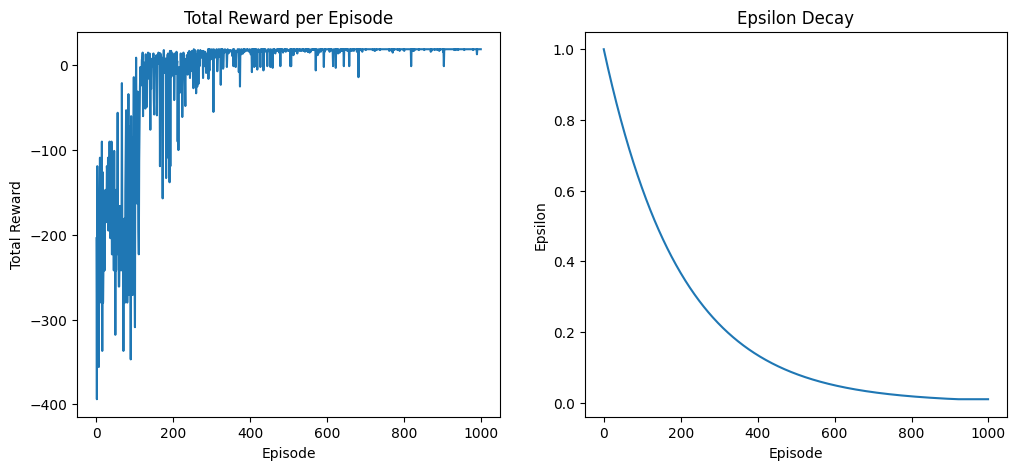

In [7]:
env = Env_3_Drone_Delivery()
state_dim = 3  # (x, y, has_package)
action_dim = len(env.actions)
agent = DQNAgent(state_dim, action_dim)
train_dqn(env, agent, episodes=1000)

torch.save(agent.policy_net.state_dict(), "dqn_drone_delivery.pth")

Evaluation over 5 episodes: Avg Reward = 19.00


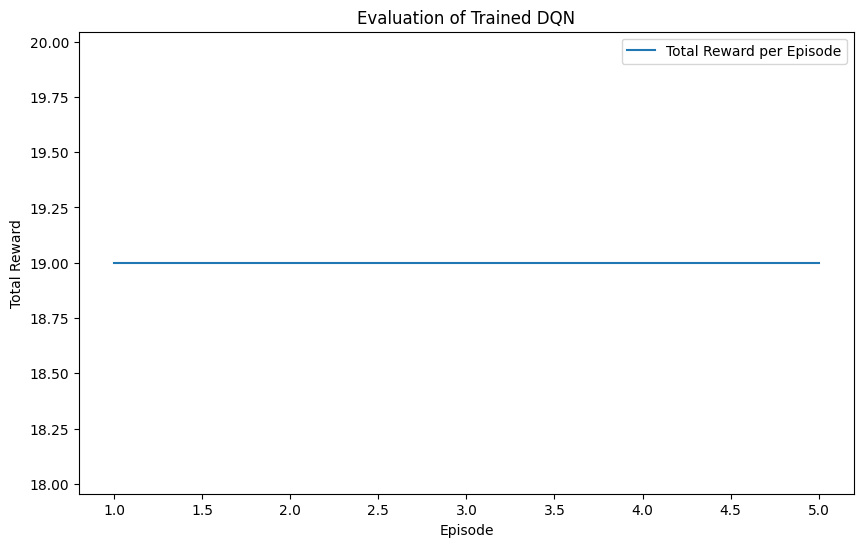

In [8]:
def evaluate_dqn(env, agent, episodes=5):
    total_rewards = []
    agent.epsilon = 0  # Disable exploration

    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            state = next_state
            total_reward += reward

            if done or truncated:
                break

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    print(f"Evaluation over {episodes} episodes: Avg Reward = {avg_reward:.2f}")
    # Plot the total reward per episode
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation of Trained DQN")
    plt.legend()
    plt.show()
    return avg_reward

avg_reward = evaluate_dqn(env, agent, episodes=5)


## Simulation

Step 1: Action PICKUP, Reward: 9, Position: (0, 0, True)


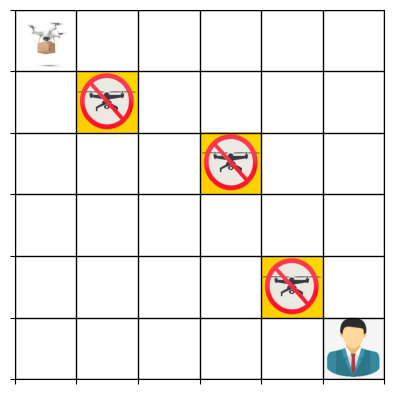

Step 2: Action DOWN, Reward: -1, Position: (1, 0, True)


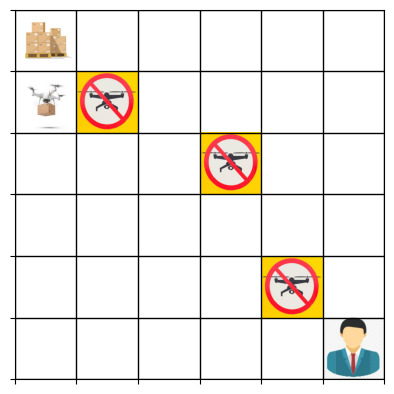

Step 3: Action DOWN, Reward: -1, Position: (2, 0, True)


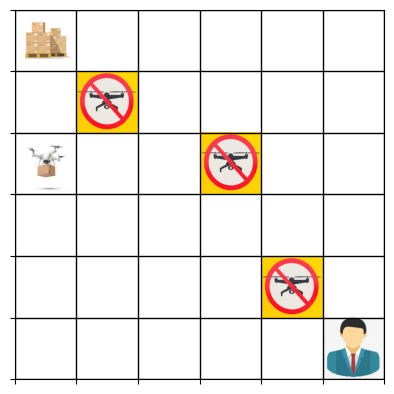

Step 4: Action RIGHT, Reward: -1, Position: (2, 1, True)


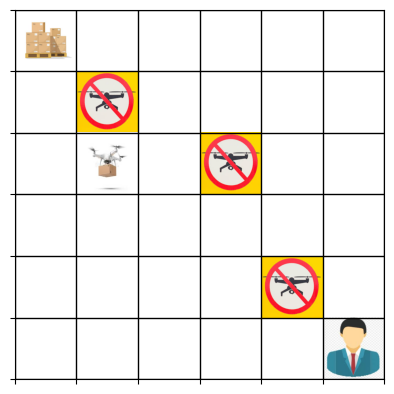

Step 5: Action DOWN, Reward: -1, Position: (3, 1, True)


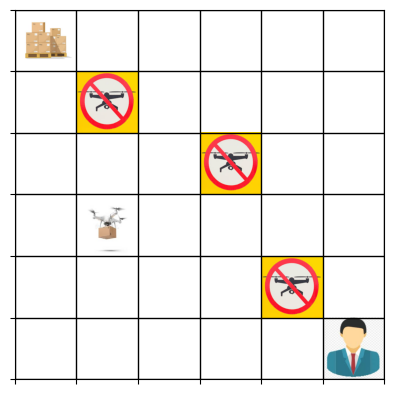

Step 6: Action RIGHT, Reward: -1, Position: (3, 2, True)


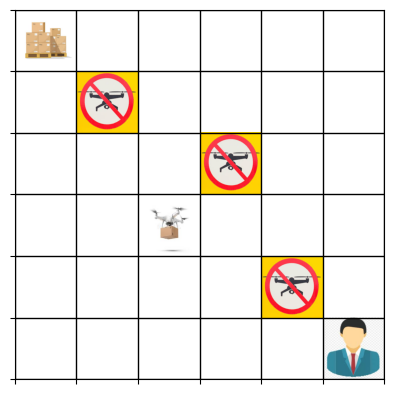

Step 7: Action DOWN, Reward: -1, Position: (4, 2, True)


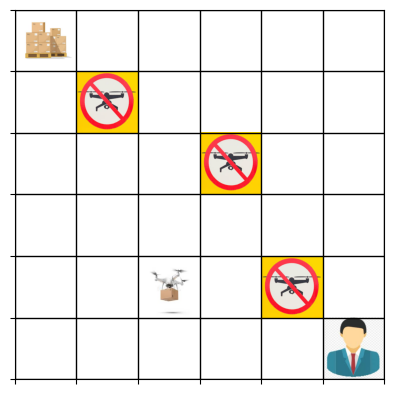

Step 8: Action RIGHT, Reward: -1, Position: (4, 3, True)


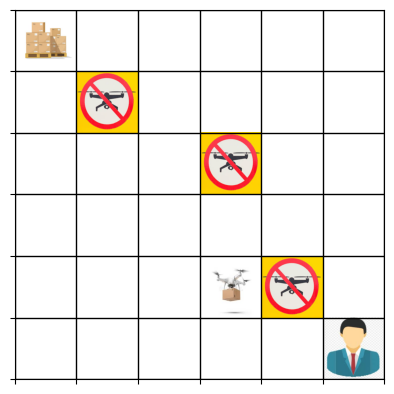

Step 9: Action DOWN, Reward: -1, Position: (5, 3, True)


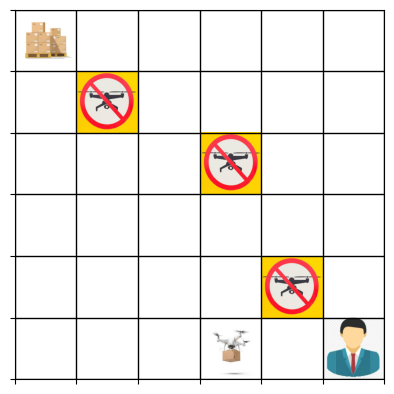

Step 10: Action RIGHT, Reward: -1, Position: (5, 4, True)


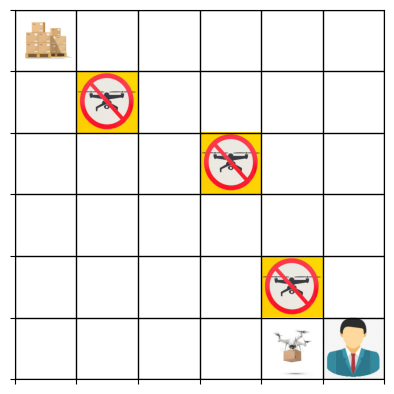

Step 11: Action RIGHT, Reward: -1, Position: (5, 5, True)


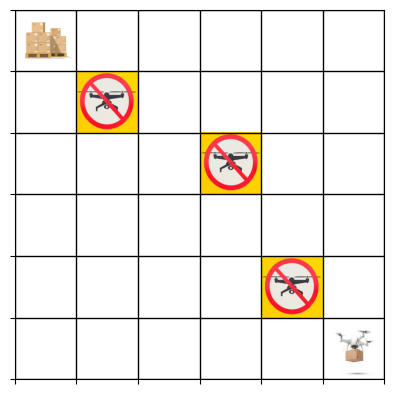

Step 12: Action DROPOFF, Reward: 20, Position: (5, 5, False)


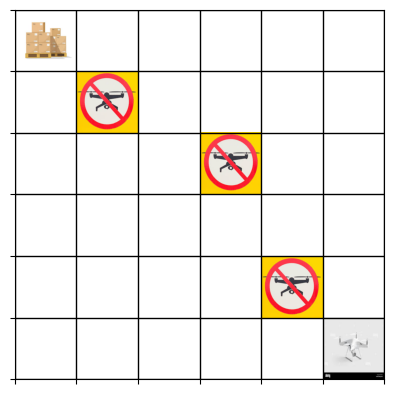

Simulation finished after 12 steps with total reward 19


In [9]:
agent.policy_net.load_state_dict(torch.load("dqn_drone_delivery.pth"))
agent.policy_net.eval()

state, _ = env.reset()
done = False
truncated = False
total_reward = 0
step_count = 0

while not done and not truncated:
    # state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = agent.select_action(state) 
    state, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    step_count += 1
    print(f"Step {step_count}: Action {env.actions[action]}, Reward: {reward}, Position: {state}")

    env.render()

print(f"Simulation finished after {step_count} steps with total reward {total_reward}")

## Cartpole-v1 Environment

Episode 10, Total Reward: 11.0, Avg Reward: 20.90, Epsilon: 0.951
Episode 20, Total Reward: 35.0, Avg Reward: 21.25, Epsilon: 0.905
Episode 30, Total Reward: 9.0, Avg Reward: 19.87, Epsilon: 0.860
Episode 40, Total Reward: 10.0, Avg Reward: 20.00, Epsilon: 0.818
Episode 50, Total Reward: 22.0, Avg Reward: 20.18, Epsilon: 0.778
Episode 60, Total Reward: 22.0, Avg Reward: 22.07, Epsilon: 0.740
Episode 70, Total Reward: 40.0, Avg Reward: 24.51, Epsilon: 0.704
Episode 80, Total Reward: 15.0, Avg Reward: 28.48, Epsilon: 0.670
Episode 90, Total Reward: 98.0, Avg Reward: 32.91, Epsilon: 0.637
Episode 100, Total Reward: 54.0, Avg Reward: 33.46, Epsilon: 0.606
Episode 110, Total Reward: 35.0, Avg Reward: 38.20, Epsilon: 0.576
Episode 120, Total Reward: 19.0, Avg Reward: 42.71, Epsilon: 0.548
Episode 130, Total Reward: 204.0, Avg Reward: 49.09, Epsilon: 0.521
Episode 140, Total Reward: 17.0, Avg Reward: 52.36, Epsilon: 0.496
Episode 150, Total Reward: 138.0, Avg Reward: 60.63, Epsilon: 0.471
Epi

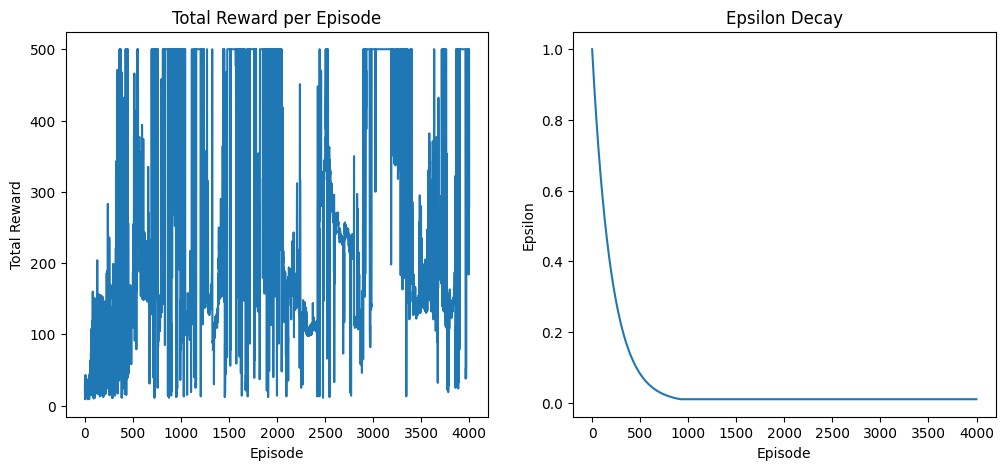

In [22]:
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from itertools import count

# Training function
def training_dqn(env, agent, episodes=1000, target_update=10):
    rewards_history = []
    epsilon_history = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated  # Proper termination handling

            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.update()
            if done:
                break

        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        agent.decay_epsilon()

        if episode % target_update == 0:
            agent.update_target_network()

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    # Plot rewards and epsilon decay
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay")

    plt.show()

# Initialize environment and agent
env1 = gym.make("CartPole-v1")
state_dim = env1.observation_space.shape[0]
action_dim = env1.action_space.n

agent1 = DQNAgent(state_dim, action_dim)
training_dqn(env1, agent1, episodes=4000)

# Save model
torch.save(agent1.policy_net.state_dict(), "dqn_cartpole.pth")

Evaluation over 10 episodes: Avg Reward = 500.00


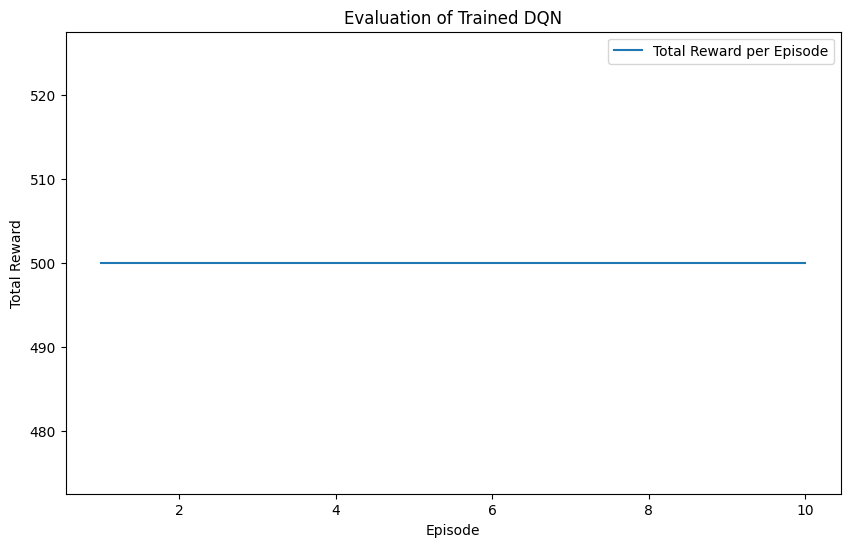

Environment solved!


In [23]:
def evaluating_dqn(env, agent, episodes=5):
    total_rewards = []
    agent.epsilon = 0 

    for episode in range(episodes):
        state,_ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, terminated,truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated
            # truncated = done
            state = next_state
            total_reward += reward

            if done or truncated:
                break

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    print(f"Evaluation over {episodes} episodes: Avg Reward = {avg_reward:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation of Trained DQN")
    plt.legend()
    plt.show()
    return avg_reward

avg_reward1 = evaluating_dqn(env1, agent1, episodes=10)

if avg_reward1 >= 470:
    print("Environment solved!")


## Frozen Lake

Episode 10, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.951
Episode 20, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.905
Episode 30, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.860
Episode 40, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.818
Episode 50, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.778
Episode 60, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.740
Episode 70, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.704
Episode 80, Total Reward: 0.0, Avg Reward: 0.01, Epsilon: 0.670
Episode 90, Total Reward: 1.0, Avg Reward: 0.06, Epsilon: 0.637
Episode 100, Total Reward: 0.0, Avg Reward: 0.08, Epsilon: 0.606
Episode 110, Total Reward: 0.0, Avg Reward: 0.10, Epsilon: 0.576
Episode 120, Total Reward: 0.0, Avg Reward: 0.11, Epsilon: 0.548
Episode 130, Total Reward: 0.0, Avg Reward: 0.11, Epsilon: 0.521
Episode 140, Total Reward: 0.0, Avg Reward: 0.12, Epsilon: 0.496
Episode 150, Total Reward: 0.0, Avg Reward: 0.12, Epsilon: 0.471
Episode 160, Total Reward: 0.0, Av

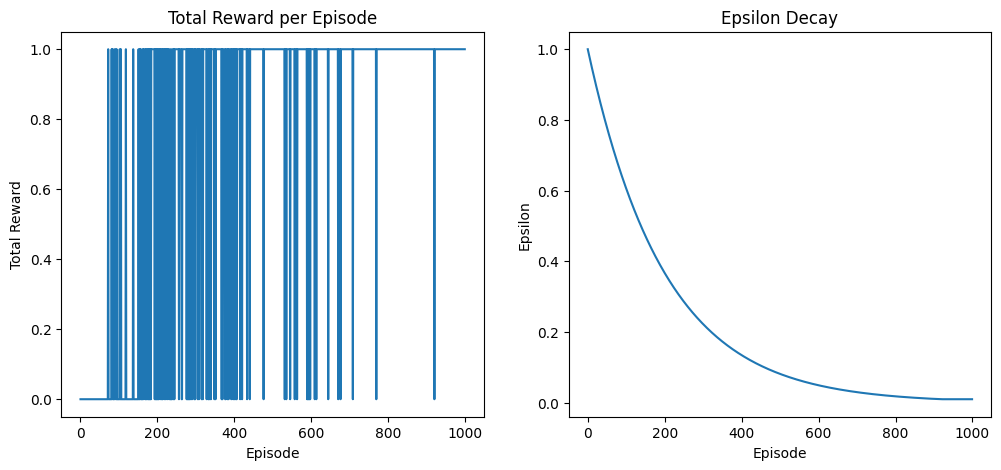

In [24]:
# Training function
def training_dqn1(env, agent, episodes=1000, target_update=10):
    rewards_history = []
    epsilon_history = []
    for episode in range(episodes):
        
        state,_ = env.reset()
        
        state = np.eye(env.observation_space.n)[state]
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, done, _,_ = env.step(action)
            
            next_state = np.eye(env.observation_space.n)[next_state]
            next_state = np.array(next_state, dtype=np.float32)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.update()
            if done:
                break
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        agent.decay_epsilon()
        if episode % target_update == 0:
            agent.update_target_network()
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            #print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')

    plt.show()

env2 = gym.make("FrozenLake-v1", is_slippery=False)
state_dim = env2.observation_space.n
action_dim = env2.action_space.n
agent2 = DQNAgent(state_dim, action_dim)
training_dqn1(env2, agent2, episodes=1000)

torch.save(agent2.policy_net.state_dict(), "dqn_frozen_lake.pth")

Evaluation over 5 episodes: Avg Reward = 1.00


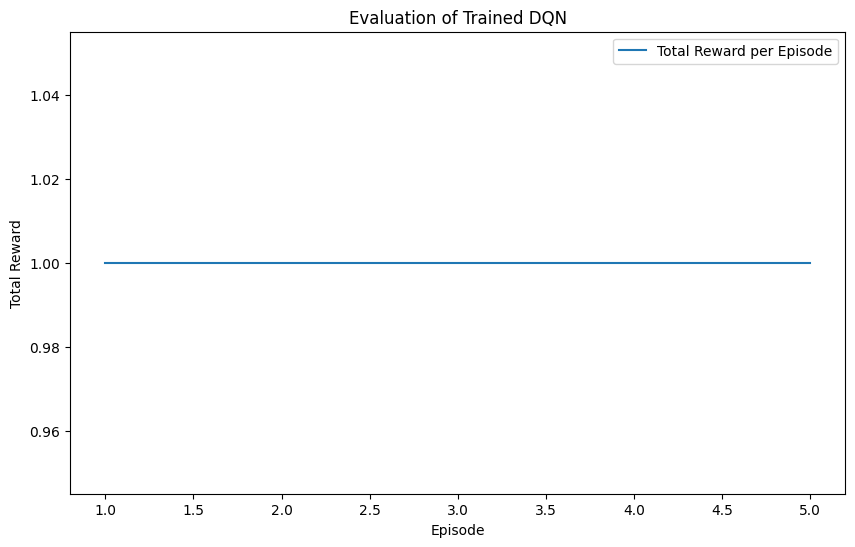

Environment solved!


In [25]:
def evaluate_dqn1(env, agent, episodes=5):
    total_rewards = []
    agent.epsilon = 0  # Disabling exploration

    for episode in range(episodes):
        state,_ = env.reset()
        
        state = np.eye(env.observation_space.n)[state]
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, done, _,_ = env.step(action)
            
            next_state = np.eye(env.observation_space.n)[next_state]
            next_state = np.array(next_state, dtype=np.float32)
            state = next_state
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    print(f"Evaluation over {episodes} episodes: Avg Reward = {avg_reward:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation of Trained DQN")
    plt.legend()
    plt.show()
    return avg_reward

avg_reward2 = evaluate_dqn1(env2, agent2, episodes=5)
if avg_reward2 >= 0.8:
    print("Environment solved!")